In [ ]:
### READING THE DATASET

import pandas as pd
import os as os
import numpy as np
# Creating empty list for broken tooth and healthy gearbox datasets
broken = []
healthy = []

# Defining the path where the datasets are stored
pth1 = 'dataset/BrokenTooth'
pth2 = 'dataset/Healthy'

# Reading the dataset as the list items using the OS library to access the files and read_csv function from pandas to read the daatasets 
# **Reading each file in the BrokenTooth and Healthy directories and appending it to the respective lists as pandas' DataFrame object (abbr.: df)
for file_name in sorted(os.listdir(pth1)):
    this_df = pd.read_csv(os.path.join(pth1, file_name))
    this_df['load'] = 10*int(file_name[5])
    this_df['gearbox_status'] = 0
    broken.append(this_df)

for file_name in sorted(os.listdir(pth2)):
    this_df = pd.read_csv(os.path.join(pth2, file_name))
    this_df['load'] = 10*int(file_name[5])
    this_df['gearbox_status'] = 1
    healthy.append(this_df)

In [ ]:
# Aggregating dataset based on health status
# broken_agg = broken[0]
# healthy_agg = healthy[0]
# for i in range(1,10):
#     broken_agg = pd.concat([broken_agg, broken[i]], ignore_index=True)
#     healthy_agg = pd.concat([healthy_agg, healthy[i]], ignore_index=True)

# print(broken[0])

In [ ]:
# import math

# def divide_into(df, n):
#     group_size = n
#     df_groups = []
#     for i in range(math.ceil(df['a1'].count()/group_size)):
#         new_df = df.iloc[i*group_size:(i+1)*group_size, :]
#         df_groups.append(new_df)
#     return df_groups

# def get_group_stdevs(df, n):
#     groups = divide_into(df, n)
#     stdevs = pd.DataFrame(map(pd.DataFrame.std, groups))
#     stdevs['load'] = df['load']
#     stdevs['gearbox_status'] = df['gearbox_status']
    
#     return stdevs

# broken_stdev = []
# for i in range(0,10):
#     broken_stdev.append(get_group_stdevs(broken[i], 100))
# print(broken_stdev[3])

# healthy_stdev = []
# for i in range(0,10):
#     healthy_stdev.append(get_group_stdevs(healthy[i], 100))
# print(healthy_stdev[3])

C:\Users\pk123\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pk123\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pk123\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

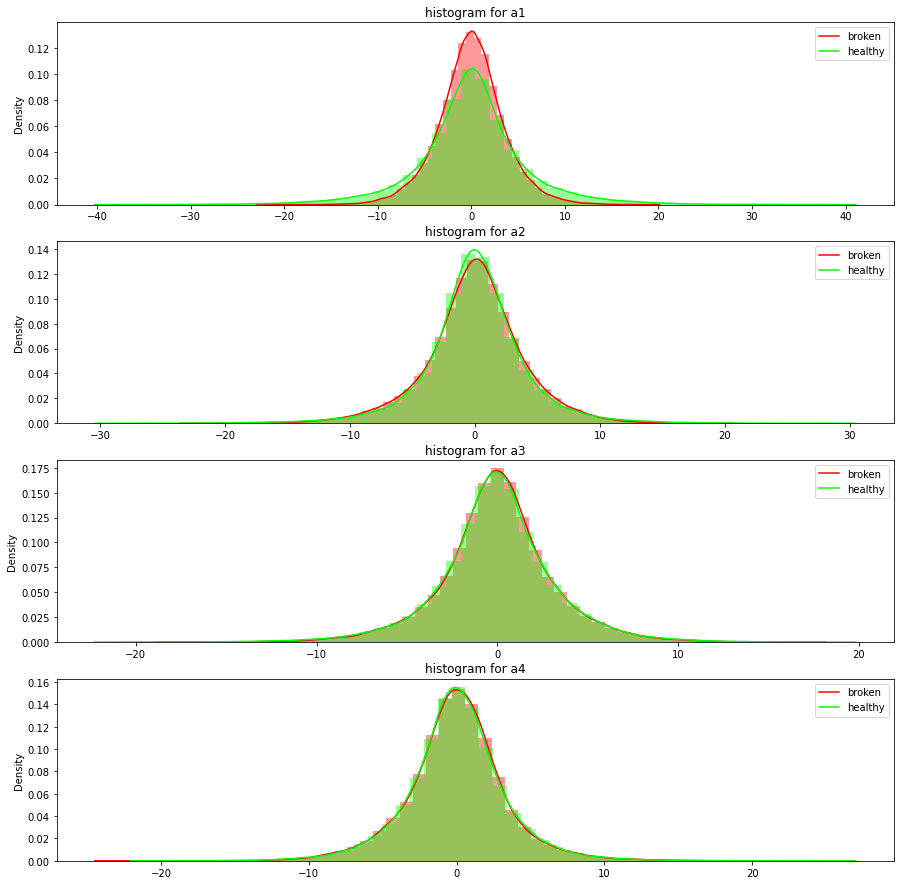

In [12]:
### DATA VISUALISATION

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

load = 0
dataset = pd.concat([broken[load], healthy[load]], axis=0)

plt.figure(figsize=(15,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(dataset[['a1','a2','a3','a4']]):
    ax = plt.subplot(gs[i])
    sns.distplot(dataset[cn][dataset.gearbox_status == 0], bins=50, color="red")
    sns.distplot(dataset[cn][dataset.gearbox_status == 1], bins= 50, color="lime")
    ax.set_xlabel('')
    plt.legend(['broken', 'healthy'])
    ax.set_title('histogram for ' + str(cn))
plt.show()